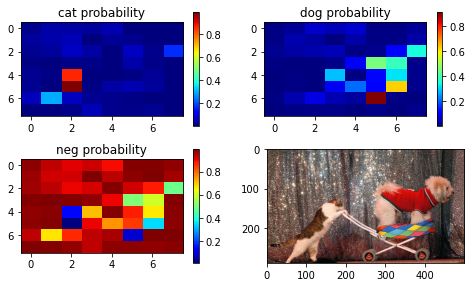

In [70]:
import argparse, pdb
import matplotlib.pyplot as plt, numpy as np, tensorflow as tf

from utils import (
    decode_jpeg,
    IMG_SIZE,
    normalize_resize_image,
    LABELS,
    maybe_makedirs,
)


def compute_brute_force_classification(model, image_path, nH=8, nW=8):
    """
    This function returns the probabilities of each window.
    Inputs:
        model: Model which is used
        image_path: path to the image to be analysed
        nH: number of windows in the vertical direction
        nW: number of windows in the horizontal direction
    Outputs:
        window_predictions: a (nH, nW, 3) np.array.
                            The last dim (size 3) is the probabilities
                            of each label (cat, dog, neg)
    HINT: normalize_resize_image  (from utils.py) will be useful here.
    HINT: If you want to predict a single image you have to add a singular batch dimesnion:
            [IMG_SIZE, IMG_SIZE, 3] -> [1, IMG_SIZE, IMG_SIZE, 3].
            Similarly predict will return a [1, 3] array which you might want to squeeze into a [3] array
    """

    # H x W x 3 numpy array (3 for each RGB color channel)
    raw_image = decode_jpeg(image_path).numpy() #(500, 409, 3)

    ######### Your code starts here #########
    window_predictions = np.zeros((nH,nW,3))
    h,w,c = raw_image.shape
    
    window_h = int(h/nH)
    window_w = int(w/nW)
    
    for i in range(nH):
        for j in range(nW):
            window_img = raw_image[i*window_h:(i+1)*window_h,j*window_w:(j+1)*window_w,:]
            padded_img = np.zeros((window_h+4,window_w+4,c))
            padded_img[2:-2,2:-2,:] = window_img
            normalized_img = normalize_resize_image(padded_img, IMG_SIZE)
            img = np.expand_dims(normalized_img, axis=0)
            pred = model(img)
            window_predictions[i,j,:] = tf.reshape(pred[0,:],[3])

    ######### Your code ends here #########

    
    return window_predictions


def compute_convolutional_KxK_classification(model, image_path):
    """
    Computes probabilities for each window based on the convolution layer of Inception
    :param model:Model which is used
    :param image_path: Path to the image to be analysed
    :return: None
    """
    raw_image = decode_jpeg(image_path).numpy()
    resized_patch = normalize_resize_image(raw_image, IMG_SIZE)
    conv_model = tf.keras.Model(
        model.layers[0].inputs, model.layers[0].layers[-2].output
    )

    ######### Your code starts here #########
    # Fill in the parts indicated by #FILL#. No additional lines are required.

    # We want to use the output of the last convolution layer which has the shape [bs, K, K, bottleneck_size]

    # First calculate K

    # Next create a intermediate input structure which takes in a bottleneck tensor

    # Create the classifier model which takes in the bottleneck tensor and outputs the class probabilities
    # Note: you must reuse the weights (layers) from the trained model as well as the int_input

    # Predict the ouput of the convolution layer using conv_model

    # Reshape so that patches become batches and predict
    ######### Your code ends here #########

    return np.reshape(predictionsKxK, [K, K, -1])


def compute_and_plot_saliency(model, image_path):
    """
    This function computes and plots the saliency plot.
    You need to compute the matrix M detailed in section 3.1 in
    K. Simonyan, A. Vedaldi, and A. Zisserman,
    "Deep inside convolutional networks: Visualising imageclassification models and saliency maps,"
    2013, Available at https://arxiv.org/abs/1312.6034.

    :param model: Model which is used
    :param image_path: Path to the image to be analysed
    :return: None
    """
    raw_image = tf.dtypes.cast(decode_jpeg(image_path), tf.float32)

    logits_tensor = model.get_layer("classifier")
    logits_model = tf.keras.Model(model.input, logits_tensor.output)

    with tf.GradientTape() as t:
        ######### Your code starts here #########
        # Fill in the parts indicated by #FILL#. No additional lines are
        # required.

        print('Not yet implemented')

        ######### Your code ends here #########

    plt.subplot(2, 1, 1)
    plt.imshow(M)
    plt.title("Saliency with respect to predicted class %s" % LABELS[top_class])
    plt.subplot(2, 1, 2)
    plt.imshow(decode_jpeg(image_path).numpy())
    plt.savefig("../plots/saliency.png")
    plt.show()


def plot_classification(image_path, classification_array):
    nH, nW, _ = classification_array.shape
    image_data = decode_jpeg(image_path).numpy()
    aspect_ratio = float(image_data.shape[0]) / image_data.shape[1]
    plt.figure(figsize=(8, 8 * aspect_ratio))
    p1 = plt.subplot(2, 2, 1)
    plt.imshow(classification_array[:, :, 0], interpolation="none", cmap="jet")
    plt.title("%s probability" % LABELS[0])
    p1.set_aspect(aspect_ratio * nW / nH)
    plt.colorbar()
    p2 = plt.subplot(2, 2, 2)
    plt.imshow(classification_array[:, :, 1], interpolation="none", cmap="jet")
    plt.title("%s probability" % LABELS[1])
    p2.set_aspect(aspect_ratio * nW / nH)
    plt.colorbar()
    p2 = plt.subplot(2, 2, 3)
    plt.imshow(classification_array[:, :, 2], interpolation="none", cmap="jet")
    plt.title("%s probability" % LABELS[2])
    p2.set_aspect(aspect_ratio * nW / nH)
    plt.colorbar()
    plt.subplot(2, 2, 4)
    plt.imshow(image_data)
    plt.savefig("../plots/detect.png")
    plt.show()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--image", type=str)
    parser.add_argument("--scheme", type=str)
    FLAGS, _ = parser.parse_known_args()
    maybe_makedirs("../plots")

    model = tf.keras.models.load_model("./trained_models/trained.h5")
    model.__call__ = tf.function(model.__call__)

    writer = tf.summary.create_file_writer("retrain_logs")
    tf.summary.trace_on()

    FLAGS.image = 'datasets/catswithdogs/002034.jpg'
    FLAGS.scheme = 'brute'
    
    if FLAGS.scheme == "brute":
        plot_classification(
            FLAGS.image,
            compute_brute_force_classification(model, FLAGS.image, 8, 8),
        )
    elif FLAGS.scheme == "conv":
        plot_classification(
            FLAGS.image,
            compute_convolutional_KxK_classification(model, FLAGS.image),
        )
    elif FLAGS.scheme == "saliency":
        compute_and_plot_saliency(model, FLAGS.image)
    else:
        print("Unrecognized scheme:", FLAGS.scheme)

    with writer.as_default():
        tf.summary.trace_export("detect_%s" % FLAGS.scheme, step=0)

